# Back to the Future : Time Travelling through Wikispeedia

## Part 0 : Preprocessing of data

#### Setting the environment 
Please check SETUP.md and pip_requirements.txt before running this notebook.

In [1]:
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import os as os
import sys
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

sys.path.append('../') 
sys.path.append('../data/') 
from src.scripts.loading_data import *
from src.utils.data_utils import *
from src.scripts.plotting import *

Some definitions:
- source article: the initial point of a game
- target article: the final point that players are looking for.
- path: all the articles visited by the player during his/her game, including the source and target articles (if the latter is found)


## Part 1 : Defining the best moment to play Wikispeedia

### 1.0) Introduction
The start point of our journey is situated in the past, in 2007. We investigate possible reasons of failure at the Wikispeedia game on articles from 2007. For this purpose, we use the dataset furnished [1][2].


### 1.1) Exploring categories
The categories of the articles are given in the `categories.tsv` file.

#### 1.1.1) Cleaning the categories

In [2]:
articles2007, links2007 = loading_articles_links('2007')

categories = loading_cleaned_categories()
print(f'Shape of categories df: {categories.shape}, number of unique articles in categories.tsv: {categories.index.unique().shape}, number of articles in articles.tsv: {articles2007.article_2007.unique().shape}')

Shape of categories df: (5204, 3), number of unique articles in categories.tsv: (5204,), number of articles in articles.tsv: (4604,)


Wait a minute... There is more rows in categories than the number of articles. Some articles have more than 1 category! In addition, there are less unique appearance of articles than the total number of articles in `articles.tsv`! We want to fix that for our Sankey diagram. First let's find the 6 articles missing in `categories.tsv`.

In [3]:
articles_not_in_categories = art_not_in_cat(articles2007, categories, 'article_2007')
articles_not_in_categories

array(['Directdebit', 'Donation', 'Friend_Directdebit', 'Pikachu',
       'Sponsorship_Directdebit', 'Wowpurchase'], dtype=object)

We got them. Let's keep them here for later, it might be useful. Now let's deal with articles having several categories. First, let's find them.

In [4]:
categories.article.value_counts().value_counts()

count
1    4000
2     590
3       8
Name: count, dtype: int64

4000 articles have only 1 category, 590 have 2 categories and 8 of them have 3 categories.

In [5]:
categories_duplicated = categories.loc[categories.index.duplicated(keep=False)]
categories_duplicated

,article,category,main_category


In [6]:
categories.loc[categories[['article', 'main_category']].duplicated(keep=False)]

,article,category,main_category
177,Al_Jazeera,"[Citizenship, Media]",Citizenship
178,Al_Jazeera,"[Citizenship, Politics_and_government]",Citizenship
205,Alfred_the_Great,"[People, Military_People]",People
206,Alfred_the_Great,"[People, Monarchs_of_Great_Britain]",People
297,Animation,"[Everyday_life, Computer_and_Video_games]",Everyday_life
...,...,...,...
5046,Whipworm,"[Science, Biology, Organisms]",Science
5051,White_cliffs_of_Dover,"[Geography, Geography_of_Great_Britain]",Geography
5052,White_cliffs_of_Dover,"[Geography, Geology_and_geophysics]",Geography
5068,William_Ewart_Gladstone,"[People, Historical_figures]",People


We notice that some articles have the same main category but the subcategories are different. Let's focus on the main category and get rid off the other subcategories. We keep delete one the duplicated main category for every concerned article. 

In [7]:
categories = categories.drop(index=categories.loc[categories[['article', 'main_category']].duplicated()].index)
categories

,article,category,main_category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[History, British_History, British_History_150...",History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[People, Historical_figures]",People
2,%C3%85land,[Countries],Countries
3,%C3%85land,"[Geography, European_Geography, European_Count...",Geography
4,%C3%89douard_Manet,"[People, Artists]",People
...,...,...,...
5199,Zirconium,"[Science, Chemistry, Chemical_elements]",Science
5200,Zoroaster,"[People, Religious_figures_and_leaders]",People
5201,Zuid-Gelders,"[Geography, European_Geography]",Geography
5202,Zuid-Gelders,"[Language_and_literature, Languages]",Language_and_literature


In [8]:
# let's check if this problem is solved, i.e. this command return an empty df
categories.loc[categories[['article', 'main_category']].duplicated(keep=False)]

,article,category,main_category


In [9]:
# update the df containing only duplicated articles. We have deleted 90 useless rows. 
categories_duplicated = categories.loc[categories.article.duplicated(keep=False)]
categories_duplicated

,article,category,main_category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[History, British_History, British_History_150...",History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[People, Historical_figures]",People
2,%C3%85land,[Countries],Countries
3,%C3%85land,"[Geography, European_Geography, European_Count...",Geography
5,%C3%89ire,[Countries],Countries
...,...,...,...
5193,Zimbabwe,[Countries],Countries
5197,Zionism,"[People, Political_People]",People
5198,Zionism,"[Religion, Religious_movements_traditions_and_...",Religion
5201,Zuid-Gelders,"[Geography, European_Geography]",Geography


It looks better, but we still have 1013 rows to sort out. From now on, we will do purely arbitrary choices to keep only one main category.
You can find the logical reasoning and examples of paths concerned in `categories_partial_ordering.md`. Using this partial ordering, we can kick out the duplicated articles we do not want.

In [10]:

relationships = [('History', 'People'), ('Religion', 'People'), ('Language_and_literature', 'People'),
 ('Science', 'People'), ('Religion', 'History'), ('Countries', 'Geography'), ('Language_and_literature', 'Geography'), 
 ('Language_and_literature', 'Design_and_Technology'), ('Language_and_literature', 'History'), ('Science', 'Everyday_life'), 
 ('Science', 'Design_and_Technology'), ('Geography', 'Design_and_Technology'), ('Design_and_Technology', 'History'), 
 ('Mathematics', 'Everyday_life'), ('Everyday_life', 'People'), ('Everyday_life', 'History'), ('Geography', 'History'),
 ('Geography', 'Citizenship'), ('Design_and_Technology', 'Citizenship'), ('Design_and_Technology', 'Everyday_life'),
 ('Science', 'Citizenship'), ('IT', 'Business_Studies'), ('Business_Studies', 'Geography'), ('Business_Studies', 'People'),
 ('Everyday_life', 'Citizenship'), ('Business_Studies', 'Everyday_life'), ('Everyday_life', 'People'), ('IT', 'Science'),
 ('Geography', 'Everyday_life'), ('Science', 'Geography'), ('Business_Studies', 'History'), ('History', 'Citizenship'),
 ('Science', 'History'), ('Science', 'Business_Studies'), ('Art', 'Everyday_life'), ('Art', 'Business_Studies'),
 ('Art', 'Design_and_Technology'), ('Music', 'History'), ('Religion', 'Citizenship'), ('IT', 'Design_and_Technology'),
 ('IT', 'Citizenship'), ('Business_Studies', 'Citizenship'), ('Art', 'History'), ('IT', 'History'), 
 ('Science', 'Religion'), ('Language_and_literature', 'Art'), ('Design_and_Technology', 'People')]

categories, categories_duplicated = delete_duplicates_cat(categories, relationships)

print(f'Number of unique article names in categories: {categories.article.unique().size}, number of rows: {categories.article.size}.')

categories = categories.set_index('article') # easier for the following

display(categories_duplicated) # is empty, as expected

Number of unique article names in categories: 4598, number of rows: 4598.


,article,category,main_category


In [11]:
plot_cat_pie_chart(categories)

#### 1.1.2) Links and categories

Now each article has only one category assigned. We can thus work with the categories. First, let's analyse where links present in an article of a given category send the player: in the same category, or in another one?


In [12]:
# have to check that the articles present in the links.tsv are in categories.tsv

# retrieve all the article names present in links.tsv
articles_names_from_links = list(links2007.linkSource.unique()) + list(links2007.linkTarget.unique())

# keep 1 occurence per name only
articles_names_from_links = pd.DataFrame.from_dict({'article': list(set(articles_names_from_links))})

# find the articles that are not in categories.tsv
articles_to_drop = art_not_in_cat(articles_names_from_links, categories, 'article', index=True)
print(f'{len(articles_to_drop)} articles have to be dropped: {articles_to_drop}')

# We drop them because we can not associate a category to them:
links2007 = links2007.loc[~links2007.linkSource.isin(articles_to_drop) & ~links2007.linkTarget.isin(articles_to_drop)]

# We add columns containing the categories of the source and target articles
links2007['catSource'] = links2007['linkSource'].map(lambda x: categories.main_category.loc[x])
links2007['catTarget'] = links2007['linkTarget'].map(lambda x: categories.main_category.loc[x])

links2007

4 articles have to be dropped: ['Directdebit' 'Pikachu' 'Sponsorship_Directdebit' 'Friend_Directdebit']


,linkSource,linkTarget,catSource,catTarget
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede,History,History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba,History,People
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata,History,History
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain,History,History
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland,History,Countries
...,...,...,...,...
119877,Zulu,South_Africa,Geography,Countries
119878,Zulu,Swaziland,Geography,Countries
119879,Zulu,United_Kingdom,Geography,Countries
119880,Zulu,Zambia,Geography,Countries


In [13]:
distrib_links, num_links = get_sankey_data(links2007, categories, 'links')


cats = sorted(categories.main_category.unique())
plot_heatmap(distrib_links.reshape(15, 15), cats, num_links, 'links', gamma=0.45)

#### 1.1.3) Category of the source and target articles
Let's analyse the category of the source and target articles between the finished and unfinished paths to determine if it has an influence on the game outcomes.  

In [14]:
path_finished, path_unfinished = loading_paths()

# let's check again that all the article names of interest are present in categories.tsv
articles_not_in_categories = list(articles_not_in_categories) + list(art_not_in_cat(path_finished, categories, 'start', True))

articles_not_in_categories += list(art_not_in_cat(path_finished, categories, 'end', True))
articles_not_in_categories += list(art_not_in_cat(path_unfinished, categories, 'start', True))
articles_not_in_categories += list(art_not_in_cat(path_unfinished, categories, 'target', True))

articles_not_in_categories = list(set(articles_not_in_categories))
print(f'{len(articles_not_in_categories)} articles do not appear in categories.tsv: {np.array(articles_not_in_categories)}')

# let's remove these paths and add new columns with categories and path length
path_finished, path_unfinished = cleaned_paths(path_finished, path_unfinished, categories, articles_not_in_categories)

31 articles do not appear in categories.tsv: ['Black_ops_2' 'Rss' 'Kashmir' 'Sponsorship_Directdebit' 'Wowpurchase'
 'The' 'Rat' 'Western_Australia' 'Donation' 'Netbook' 'English' 'Georgia'
 'Christmas' 'C++' 'Test' 'Sportacus' 'Pikachu' 'Long_peper' 'Macedonia'
 'Directdebit' 'Bogota' 'The_Rock' 'Charlottes_web' 'Adolph_Hitler'
 'Mustard' 'Podcast' 'Fats' 'Usa' 'Friend_Directdebit' 'Great' '_Zebra']
Initial number of rows in path finished: 51318, current number of rows: 51249, percentage of loss: 0.13%
Initial number of rows in path unfinished: 24875, current number of rows: 19607, percentage of loss: 21.18%


Oof, we are not loosing much data, we can consider this correction as negligble. Let's get the data for the sankey plot. 

In [15]:
path_unfinished

,hashedIpAddress,timestamp,durationInSec,path,target,type,start,end,catSource,catTarget,catEnd,length
2,2b015fb8181c48f2,1297090819,1818,"[Malawi, Democracy, Alexander_the_Great]",First_Crusade,timeout,Malawi,Alexander_the_Great,Countries,Religion,People,3
4,53a53bc244e08a6a,1297099105,1808,"[Paraguay, Bolivia]",Mount_St._Helens,timeout,Paraguay,Bolivia,Countries,Geography,Countries,2
5,131600803df4895e,1297100557,2009,"[Agriculture, History_of_the_world, China, Yan...",Grand_Canal_of_China,timeout,Agriculture,Yangtze_River,Everyday_life,Geography,Geography,4
6,486bb79910fe9dd2,1297101660,1932,"[Mind, Christianity, Europe, Renaissance, Anci...",Scouting,timeout,Mind,Asia,Religion,Citizenship,Geography,7
7,6d136e371e42474f,1297102070,175,"[4-2-0, United_States, Agriculture, Sugar, Aus...",Cane_Toad,restart,4-2-0,Australia,Design_and_Technology,Science,Countries,5
...,...,...,...,...,...,...,...,...,...,...,...,...
24869,109ed71f571d86e9,1389787212,182,"[Turks_and_Caicos_Islands, United_States, Iraq...",Iraq_War,restart,Turks_and_Caicos_Islands,War,Countries,History,History,6
24870,109ed71f571d86e9,1389787605,180,"[Franz_Kafka, Tuberculosis, World_Health_Organ...",Cholera,restart,Franz_Kafka,Ghana,People,Science,Countries,8
24872,2e09a7224600a7cd,1389798400,1900,"[Computer_programming, Linguistics, Culture, P...",The_Beatles,timeout,Computer_programming,Popular_culture,IT,Music,Everyday_life,5
24873,60af9e2138051b96,1389799481,1903,"[Jamaica, United_Kingdom, World_War_II, Battle...",Alan_Turing,timeout,Jamaica,Battle_of_Midway,Countries,People,History,4


In [16]:
distrib_f, tot_links_f = get_sankey_data(path_finished, categories, 'f')
distrib_unf, tot_links_unf = get_sankey_data(path_unfinished, categories, 'unf')
distrib_unf_start2end, distrib_unf_end2target, tot_links_start2end, tot_links_end2target = get_multistep_sankey_data(path_unfinished, categories)

global_min = min(np.min(distrib_links), np.min(distrib_f), np.min(distrib_unf), np.min(distrib_unf_start2end)) * 100
global_max = max(np.max(distrib_links), np.max(distrib_f), np.max(distrib_unf), np.max(distrib_unf_start2end)) * 100


all_to_cat_f, cat_to_all_f = plot_heatmap(distrib_f.reshape(15, 15), cats, tot_links_f, 'f', vmin=global_min, vmax=global_max, gamma=0.45, stats=True)
all_to_cat_unf, cat_to_all_unf = plot_heatmap(distrib_unf.reshape(15, 15), cats, tot_links_unf, 'unf', vmin=global_min, vmax=global_max, gamma=0.45, stats=True)
plot_heatmap(distrib_unf.reshape(15, 15), cats, tot_links_unf, 'unf', vmin=global_min, vmax=global_max, gamma=0.45)
plot_heatmap(distrib_unf_start2end.reshape(15, 15), cats, tot_links_unf, 'unf_start', vmin=global_min, vmax=global_max, gamma=0.45)
plot_heatmap(distrib_unf_end2target.reshape(15, 15), cats, tot_links_unf, 'unf_target', vmin=global_min, vmax=global_max, gamma=0.45)

In [17]:
print(all_to_cat_f)
print(all_to_cat_unf)

{'Art': 0.6380612304630335, 'Business_Studies': 1.406856719155496, 'Citizenship': 3.4576284415305665, 'Countries': 8.103572752639078, 'Design_and_Technology': 4.958145524790728, 'Everyday_life': 6.51524907803079, 'Geography': 16.950574645358934, 'History': 9.586528517629613, 'IT': 2.620538937345119, 'Language_and_literature': 2.499560967043259, 'Mathematics': 1.0536790961774865, 'Music': 1.836133387968546, 'People': 9.668481336221195, 'Religion': 3.4673847294581357, 'Science': 27.23760463618802}
{'Art': 0.6681287295353701, 'Business_Studies': 1.820778293466619, 'Citizenship': 4.069975008925383, 'Countries': 2.065588820319274, 'Design_and_Technology': 8.083847605447033, 'Everyday_life': 10.766562962207374, 'Geography': 10.567654409139593, 'History': 9.603712959657265, 'IT': 2.5603100933340133, 'Language_and_literature': 3.7996633855255775, 'Mathematics': 0.7803335543428367, 'Music': 2.443005049217116, 'People': 8.991686642525629, 'Religion': 2.233896057530474, 'Science': 31.544856428826

In [22]:
print(cat_to_all_f)
print(cat_to_all_unf)

{'Art': 0.7766005190345178, 'Business_Studies': 1.633202599075104, 'Citizenship': 3.547386290464204, 'Countries': 5.633280649378525, 'Design_and_Technology': 4.854728872758493, 'Everyday_life': 9.522137017307655, 'Geography': 14.556381587933423, 'History': 7.746492614490038, 'IT': 2.3434603602021506, 'Language_and_literature': 4.915217857909423, 'Mathematics': 1.160998263380749, 'Music': 1.806864524185838, 'People': 9.321157485999727, 'Religion': 2.866397393119865, 'Science': 29.315693964760285}
{'Art': 0.8211353088182791, 'Business_Studies': 1.5147651349008004, 'Citizenship': 3.2896414545825468, 'Countries': 5.1665221604528995, 'Design_and_Technology': 7.99714387718672, 'Everyday_life': 8.721375019125823, 'Geography': 13.270770643137656, 'History': 7.2066098842250215, 'IT': 2.17269342581731, 'Language_and_literature': 6.803692558780027, 'Mathematics': 1.2444535115009945, 'Music': 1.6575712755648493, 'People': 8.323557912990259, 'Religion': 2.805120620186668, 'Science': 29.004947212730

We can see differences between the proportions. But are they significiant?

In [25]:
# NEXTSTEP:: check one more time that we use the right statistical test

from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
# from scipy.stats import bartlett
# predictor: categorical, 2 of them: start and end
# outcome: continuous (in N)
# ==> anova
# Null hypothesis: the distributions are different.
# Alternative hypothesis: the distributions are identic.

f_oneway(distrib_f, distrib_unf)
# p-value = 1 >>>> 0.05 ==> can't say it's different 


print(chi2_contingency_test(distrib_f*tot_links_f, distrib_unf*tot_links_unf))
print(chi2_contingency_test(distrib_f*tot_links_f, distrib_unf_start2end*tot_links_start2end))
print(chi2_contingency_test(distrib_f*tot_links_f, distrib_unf_end2target*tot_links_end2target))
print(chi2_contingency_test(distrib_unf_start2end*tot_links_start2end, distrib_unf_end2target*tot_links_end2target))
print(chi2_contingency_test(np.array(list(all_to_cat_f.values()))*tot_links_f, np.array(list(all_to_cat_unf.values()))*tot_links_unf))
print(chi2_contingency_test(np.array(list(cat_to_all_f.values()))*tot_links_f, np.array(list(cat_to_all_unf.values()))*tot_links_unf))

(0.0, 2953.306794291134)
(0.0, 4383.703330901606)
(0.0, 10132.941451042401)
(0.0, 8204.090707335448)
(0.0, 207557.75636787878)
(0.0, 39997.7909730497)


We can not say that the distribution of categories are different.

Some paths are really short: it seems like the player didn't even try to play... Let's remove the paths with a length smaller or equal to 3 (i.e. the player clicked on 2 links at most). Does it change something? 

In [18]:
path_unfinished_trunc = path_unfinished.copy(deep=True)
path_unfinished_trunc = path_unfinished_trunc.loc[path_unfinished_trunc.path.map(lambda x: len(x)>=4)]
path_unfinished_trunc


,hashedIpAddress,timestamp,durationInSec,path,target,type,start,end,catSource,catTarget,catEnd,length
5,131600803df4895e,1297100557,2009,"[Agriculture, History_of_the_world, China, Yan...",Grand_Canal_of_China,timeout,Agriculture,Yangtze_River,Everyday_life,Geography,Geography,4
6,486bb79910fe9dd2,1297101660,1932,"[Mind, Christianity, Europe, Renaissance, Anci...",Scouting,timeout,Mind,Asia,Religion,Citizenship,Geography,7
7,6d136e371e42474f,1297102070,175,"[4-2-0, United_States, Agriculture, Sugar, Aus...",Cane_Toad,restart,4-2-0,Australia,Design_and_Technology,Science,Countries,5
9,6d136e371e42474f,1297104110,2006,"[Logic, Computer_science, Science, Physical_sc...",Moon_landing,timeout,Logic,Neil_Armstrong,Religion,Science,People,9
10,430ca00e7f5303b7,1297126187,1976,"[Battle_of_Gettysburg, Washington%2C_D.C., Uni...",Ostrich,timeout,Battle_of_Gettysburg,Animal,History,Science,Science,7
...,...,...,...,...,...,...,...,...,...,...,...,...
24869,109ed71f571d86e9,1389787212,182,"[Turks_and_Caicos_Islands, United_States, Iraq...",Iraq_War,restart,Turks_and_Caicos_Islands,War,Countries,History,History,6
24870,109ed71f571d86e9,1389787605,180,"[Franz_Kafka, Tuberculosis, World_Health_Organ...",Cholera,restart,Franz_Kafka,Ghana,People,Science,Countries,8
24872,2e09a7224600a7cd,1389798400,1900,"[Computer_programming, Linguistics, Culture, P...",The_Beatles,timeout,Computer_programming,Popular_culture,IT,Music,Everyday_life,5
24873,60af9e2138051b96,1389799481,1903,"[Jamaica, United_Kingdom, World_War_II, Battle...",Alan_Turing,timeout,Jamaica,Battle_of_Midway,Countries,People,History,4


We got rid of roughly 10 000 paths! 

In [19]:
distrib_unf_trunc, tot_links_unf_trunc = get_sankey_data(path_unfinished, categories, 'unf')
plot_heatmap(distrib_unf_trunc.reshape(15,15), cats, tot_links_unf, 'unf_target', vmin=global_min, vmax=global_max, gamma=0.45)

In [20]:
plot_heatmap_differences(distrib_f.reshape(15, 15), distrib_unf.reshape(15, 15), cats, tot_links_f)

In [21]:
# NEXTSTEP:: check one more time that we use the right statistical test
# same test
f_oneway(distrib_f, distrib_unf_trunc)

F_onewayResult(statistic=1.1819300616721256e-08, pvalue=0.9999133051341907)

But we can still not say that the distribution is different... what if we take a higher threshold to count an unfinished path as a proper game? 

In [22]:
# NEXTSTEP:: check one more time that we use the right statistical test
for i in range(2, 20):
    path_unfinished_trunc = path_unfinished.copy(deep=True)
    path_unfinished_trunc = path_unfinished_trunc.loc[path_unfinished_trunc.path.map(lambda x: len(x)>=i)]
    
    distrib_unf_trunc, tot_unf_trunc = get_sankey_data(path_unfinished_trunc, categories, 'unf', suffix_fn=str(i))

    stat, pval_anova = f_oneway(distrib_f, distrib_unf_trunc)
    pval, stat_chi2 = chi2_contingency_test(distrib_f*tot_links_f, distrib_unf_trunc*tot_unf_trunc)
    
    print(f'i={i}, number of rows kept:{path_unfinished_trunc.shape[0]}, percentage of rows kept:{100-(path_unfinished.shape[0]-path_unfinished_trunc.shape[0])/path_unfinished.shape[0]*100:.2f}%, pval anova={pval_anova:.3f}, pval ttest={pval:.3f}')

i=2, number of rows kept:19607, percentage of rows kept:100.00%, pval anova=1.000, pval ttest=0.000
i=3, number of rows kept:16390, percentage of rows kept:83.59%, pval anova=1.000, pval ttest=0.000
i=4, number of rows kept:13234, percentage of rows kept:67.50%, pval anova=1.000, pval ttest=0.000
i=5, number of rows kept:10514, percentage of rows kept:53.62%, pval anova=1.000, pval ttest=0.000
i=6, number of rows kept:8060, percentage of rows kept:41.11%, pval anova=1.000, pval ttest=0.000
i=7, number of rows kept:6280, percentage of rows kept:32.03%, pval anova=1.000, pval ttest=0.000
i=8, number of rows kept:4849, percentage of rows kept:24.73%, pval anova=1.000, pval ttest=0.000
i=9, number of rows kept:3893, percentage of rows kept:19.86%, pval anova=1.000, pval ttest=0.000
i=10, number of rows kept:3099, percentage of rows kept:15.81%, pval anova=1.000, pval ttest=0.000
i=11, number of rows kept:2520, percentage of rows kept:12.85%, pval anova=1.000, pval ttest=0.000
i=12, number 

Mmm, the pvalue is below the level of significiance of 0.05 only for paths longer than 15 articles, i.e. when the player clicked on at least 14 links. Considering these long paths only reduces considerably the percentages of data considered, making the sample too small to be significantly relevant. Thus, we can conclude quite safely that the category of the start and target articles is not the main reason behind failure.

### 1.2) Comparison between unfinished and finished paths for the same game: what influences the success rate?

Let's compare unfinished and finished paths with same source and target to check if some games lead to more withdraw than others.

In [23]:
path_finished_reduced = path_finished[['start', 'end', 'path', 'rating']].copy(deep=True).set_index(['start', 'end'], drop=True)
path_unfinished_reduced = path_unfinished[['start', 'target', 'path', 'end']].copy(deep=True).set_index(['start', 'target'], drop=True)
# Let's ignore unfinished paths where players clicked less than 2 links: we considered that these players where not serious.
path_unfinished_reduced = path_unfinished_reduced[path_unfinished_reduced.path.str.len()>2]

## Let's compute statistics about the players paths:
stats_finished = compute_stats_games(path_finished_reduced, 'f')
stats_unfinished = compute_stats_games(path_unfinished_reduced, 'unf')

# Let's merge all these datas
stats_games = stats_finished.join(stats_unfinished, how='inner', lsuffix='_f', rsuffix='_unf').dropna().rename(columns={'count_f': 'finished', 'count_unf': 'unfinished'})

stats_games['finished'] = stats_games['finished'].astype(int)
stats_games['unfinished'] = stats_games['unfinished'].astype(int)
stats_games['tot_games_played'] = stats_games['finished']+stats_games['unfinished']
stats_games['percentage_success'] = stats_games['finished']/(stats_games['finished']+stats_games['unfinished'])*100

# stats_games = stats_games.loc[stats_games.tot_games_played>=4]

tot_success_rate = stats_games['finished'].sum()/(stats_games['finished'].sum()+stats_games['unfinished'].sum())*100
tot_success_rate
print(f'Mean success rate: {tot_success_rate:.2f}%')

display(stats_games.describe())

# display(stats_games.loc[stats_games['percentage_success']==stats_games['percentage_success'].min()])
# display(stats_games.loc[stats_games['percentage_success']==stats_games['percentage_success'].max()])

stats_games


Mean success rate: 63.97%


,finished,avg_f_path,std_f_path,sem_f_path,med_f_path,q25_f_path,q75_f_path,q10_f_path,q90_f_path,min_f_path,...,sem_unf_path,med_unf_path,q25_unf_path,q75_unf_path,q10_unf_path,q90_unf_path,min_unf_path,max_unf_path,tot_games_played,percentage_success
count,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,...,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000
mean,15.314050,9.097014,3.938667,2.026630,8.325413,7.069215,10.342975,6.385744,12.353719,5.935950,...,1.708131,6.100207,5.071798,7.520145,4.515702,8.646281,4.148760,10.018595,23.940083,60.287713
std,84.156247,4.881033,5.190165,3.291747,4.611848,3.463297,6.321926,2.957046,8.195156,2.762892,...,2.168168,3.377213,2.568449,4.458195,2.189019,5.476799,2.036565,7.799351,137.058807,14.565429
min,2.000000,2.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,15.384615
25%,2.000000,6.333333,1.414214,0.577350,6.000000,5.000000,7.000000,4.900000,7.900000,4.000000,...,0.500000,4.000000,3.500000,4.750000,3.175000,5.000000,3.000000,5.000000,5.000000,50.000000
50%,4.000000,7.732143,2.516611,1.152048,7.000000,6.000000,8.875000,5.600000,10.000000,5.000000,...,1.000000,5.000000,4.250000,6.250000,4.000000,6.950000,3.000000,8.000000,6.000000,60.000000
75%,7.000000,10.000000,4.327393,2.189360,9.000000,8.000000,11.250000,7.025000,13.625000,7.000000,...,2.041107,7.000000,5.750000,9.000000,5.000000,11.000000,4.000000,13.000000,10.000000,71.428571
max,1043.000000,50.500000,64.346717,45.500000,50.500000,30.250000,73.250000,28.300000,86.900000,27.000000,...,26.000000,35.000000,22.000000,48.000000,18.300000,55.800000,18.000000,67.000000,1625.000000,93.750000


finished  avg_f_path  std_f_path  \
start               target                                                     
14th_century        African_slave_trade            3    7.333333    2.081666   
                    Elizabeth_I_of_England         5    7.200000    5.019960   
                    Rainbow                       27    7.444444    3.630356   
1973_oil_crisis     Bohemian_Rhapsody              2    7.000000    0.000000   
19th_century        Lord_Voldemort                 2    9.500000    4.949747   
...                                              ...         ...         ...   
William_Shakespeare Television                     3    5.666667    1.154701   
Wolverine           Minimum_wage                   3   10.666667    9.291573   
World_Wide_Web      Color                          3    8.000000    4.358899   
Yak                 Harry_Potter                   2    5.500000    0.707107   
Zebra               Sassanid_Empire                3   10.333333    6.806859   

                                            sem_f_path  med_f_path  \
start               target                                           
14th_century        African_slave_trade       1.201850         8.0   
                    Elizabeth_I_of_England    2.244994         6.0   
                    Rainbow                   0.698662         7.0   
1973_oil_crisis     Bohemian_Rhapsody         0.000000         7.0   
19th_century        Lord_Voldemort            3.500000         9.5   
...                                                ...         ...   
William_Shakespeare Television                0.666667         5.0   
Wolverine           Minimum_wage              5.364492         8.0   
World_Wide_Web      Color                     2.516611         6.0   
Yak                 Harry_Potter              0.500000         5.5   
Zebra               Sassanid_Empire           3.929942         8.0   

                                            q25_f_path  q75_f_path  \
start               target                                           
14th_century        African_slave_trade           6.50        8.50   
                    Elizabeth_I_of_England        4.00        6.00   
                    Rainbow                       4.50        9.50   
1973_oil_crisis     Bohemian_Rhapsody             7.00        7.00   
19th_century        Lord_Voldemort                7.75       11.25   
...                                                ...         ...   
William_Shakespeare Television                    5.00        6.00   
Wolverine           Minimum_wage                  5.50       14.50   
World_Wide_Web      Color                         5.50        9.50   
Yak                 Harry_Potter                  5.25        5.75   
Zebra               Sassanid_Empire               6.50       13.00   

                                            q10_f_path  q90_f_path  \
start               target                                           
14th_century        African_slave_trade            5.6         8.8   
                    Elizabeth_I_of_England         4.0        12.0   
                    Rainbow                        4.0        13.4   
1973_oil_crisis     Bohemian_Rhapsody              7.0         7.0   
19th_century        Lord_Voldemort                 6.7        12.3   
...                                                ...         ...   
William_Shakespeare Television                     5.0         6.6   
Wolverine           Minimum_wage                   4.0        18.4   
World_Wide_Web      Color                          5.2        11.6   
Yak                 Harry_Potter                   5.1         5.9   
Zebra               Sassanid_Empire                5.6        16.0   

                                            min_f_path  ...  sem_unf_path  \
start               target                              ...                 
14th_century        African_slave_trade              5  ...      3.382964   
                    Elizabeth_I_of_Engl

,,finished,avg_f_path,std_f_path,sem_f_path,med_f_path,q25_f_path,q75_f_path,q10_f_path,q90_f_path,min_f_path,...,sem_unf_path,med_unf_path,q25_unf_path,q75_unf_path,q10_unf_path,q90_unf_path,min_unf_path,max_unf_path,tot_games_played,percentage_success
start,target,,,,,,,,,,,,,,,,,,,,,
Asteroid,Viking,1043,7.516779,3.019205,0.093487,7.0,5.0,9.0,5.0,11.0,4,...,0.208724,5.0,4.0,7.0,3.0,10.0,3,62,1545,67.508091
Brain,Telephone,1040,7.100000,3.580183,0.111017,6.0,5.0,8.0,5.0,11.0,4,...,0.134285,5.0,3.0,7.0,3.0,9.0,3,27,1625,64.000000
Pyramid,Bean,642,8.246106,4.259726,0.168118,7.0,6.0,9.0,5.0,13.0,4,...,0.180391,5.0,4.0,7.0,3.0,11.0,3,67,1382,46.454414
Theatre,Zebra,905,7.836464,3.849462,0.127960,7.0,5.0,9.0,4.0,12.0,4,...,0.158060,5.0,4.0,8.0,3.0,11.6,3,32,1480,61.148649


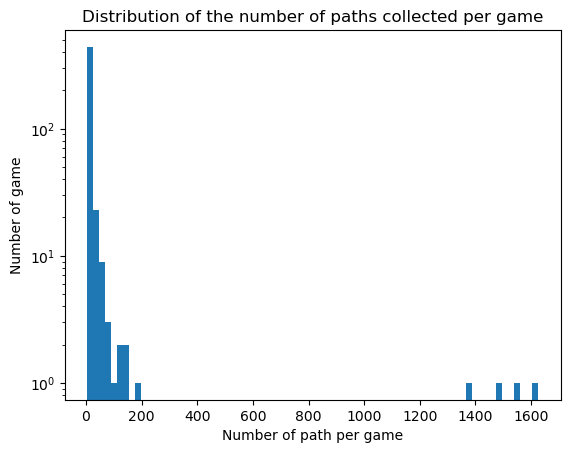

In [24]:
# NEXTSTEP:: make it pretty
plt.hist(stats_games.tot_games_played, log=True, bins=75)
plt.xlabel('Number of path per game')
plt.ylabel('Number of game')
plt.title('Distribution of the number of paths collected per game')
stats_games.loc[stats_games.tot_games_played>500]

This method presents a drawback: most games have been played only a few times... We have to keep in ,mind that we are making statistics using only a few samples per game. The few games played a lot are the ones proposed by default by the website [1].

### 1.2.1) Shortest path and succes rate

Let's look at the shortest path and the success percentage of games to determine if there is a correlation.

In [25]:
# First, we create a graph.
G_2007 = nx.DiGraph()
G_2007.add_nodes_from(np.unique(articles2007))
G_2007.add_edges_from(links2007[['linkSource', 'linkTarget']].to_numpy())

In [26]:
# some stats about the links leading to target and shortest path
stats_games['links_to_target'] = stats_games.index.map(lambda x: links2007[['linkTarget', 'linkSource']].groupby('linkTarget').count().loc[x[1]].values[0])
stats_games['log_links_to_target'] = np.log(stats_games['links_to_target'])
stats_games['shortest_path'] = stats_games.apply(lambda x: len(nx.shortest_path(G_2007, source=x.name[0], target=x.name[1])), axis=1)
stats_games

finished  avg_f_path  std_f_path  \
start               target                                                     
14th_century        African_slave_trade            3    7.333333    2.081666   
                    Elizabeth_I_of_England         5    7.200000    5.019960   
                    Rainbow                       27    7.444444    3.630356   
1973_oil_crisis     Bohemian_Rhapsody              2    7.000000    0.000000   
19th_century        Lord_Voldemort                 2    9.500000    4.949747   
...                                              ...         ...         ...   
William_Shakespeare Television                     3    5.666667    1.154701   
Wolverine           Minimum_wage                   3   10.666667    9.291573   
World_Wide_Web      Color                          3    8.000000    4.358899   
Yak                 Harry_Potter                   2    5.500000    0.707107   
Zebra               Sassanid_Empire                3   10.333333    6.806859   

                                            sem_f_path  med_f_path  \
start               target                                           
14th_century        African_slave_trade       1.201850         8.0   
                    Elizabeth_I_of_England    2.244994         6.0   
                    Rainbow                   0.698662         7.0   
1973_oil_crisis     Bohemian_Rhapsody         0.000000         7.0   
19th_century        Lord_Voldemort            3.500000         9.5   
...                                                ...         ...   
William_Shakespeare Television                0.666667         5.0   
Wolverine           Minimum_wage              5.364492         8.0   
World_Wide_Web      Color                     2.516611         6.0   
Yak                 Harry_Potter              0.500000         5.5   
Zebra               Sassanid_Empire           3.929942         8.0   

                                            q25_f_path  q75_f_path  \
start               target                                           
14th_century        African_slave_trade           6.50        8.50   
                    Elizabeth_I_of_England        4.00        6.00   
                    Rainbow                       4.50        9.50   
1973_oil_crisis     Bohemian_Rhapsody             7.00        7.00   
19th_century        Lord_Voldemort                7.75       11.25   
...                                                ...         ...   
William_Shakespeare Television                    5.00        6.00   
Wolverine           Minimum_wage                  5.50       14.50   
World_Wide_Web      Color                         5.50        9.50   
Yak                 Harry_Potter                  5.25        5.75   
Zebra               Sassanid_Empire               6.50       13.00   

                                            q10_f_path  q90_f_path  \
start               target                                           
14th_century        African_slave_trade            5.6         8.8   
                    Elizabeth_I_of_England         4.0        12.0   
                    Rainbow                        4.0        13.4   
1973_oil_crisis     Bohemian_Rhapsody              7.0         7.0   
19th_century        Lord_Voldemort                 6.7        12.3   
...                                                ...         ...   
William_Shakespeare Television                     5.0         6.6   
Wolverine           Minimum_wage                   4.0        18.4   
World_Wide_Web      Color                          5.2        11.6   
Yak                 Harry_Potter                   5.1         5.9   
Zebra               Sassanid_Empire                5.6        16.0   

                                            min_f_path  ...  q75_unf_path  \
start               target                              ...                 
14th_century        African_slave_trade              5  ...         10.50   
                    Elizabeth_I_of_Engl

Let's analyze further the "big" games, more than a certain number of times.

In [27]:
num_games = 30
stats_big_games = stats_games.copy(deep=True).loc[stats_games['tot_games_played']>=num_games].sort_values(by='percentage_success')
stats_big_games.describe()

,finished,avg_f_path,std_f_path,sem_f_path,med_f_path,q25_f_path,q75_f_path,q10_f_path,q90_f_path,min_f_path,...,q75_unf_path,q10_unf_path,q90_unf_path,min_unf_path,max_unf_path,tot_games_played,percentage_success,links_to_target,log_links_to_target,shortest_path
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,...,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,141.216216,7.081198,3.188519,0.495529,6.175676,5.121622,7.918919,4.562162,10.448649,4.189189,...,6.925676,3.167568,9.410811,3.054054,18.162162,219.621622,72.869635,95.621622,3.889121,3.837838
std,277.813200,1.561428,1.845143,0.423583,1.292157,1.016567,2.142537,0.876658,3.064458,0.810961,...,1.608209,0.478455,2.852658,0.328798,13.885471,457.331047,14.067231,144.127519,1.166748,0.646078
min,11.000000,4.333333,1.028334,0.093487,4.000000,3.000000,5.000000,3.000000,5.000000,3.000000,...,4.000000,3.000000,5.000000,3.000000,5.000000,31.000000,35.483871,3.000000,1.098612,3.000000
25%,29.000000,5.787234,1.897772,0.200167,5.000000,5.000000,6.000000,4.000000,7.900000,4.000000,...,6.000000,3.000000,7.000000,3.000000,9.000000,38.000000,65.094340,21.000000,3.044522,3.000000
50%,40.000000,7.192982,3.019205,0.376897,6.000000,5.000000,8.000000,5.000000,11.000000,4.000000,...,7.000000,3.000000,9.200000,3.000000,16.000000,51.000000,74.193548,43.000000,3.761200,4.000000
75%,69.000000,8.196429,3.655631,0.649088,7.000000,6.000000,9.000000,5.000000,12.800000,5.000000,...,7.500000,3.000000,11.600000,3.000000,20.000000,106.000000,84.313725,126.000000,4.836282,4.000000
max,1043.000000,10.588235,10.531012,2.001945,10.000000,8.000000,15.000000,6.000000,18.800000,6.000000,...,11.000000,5.000000,18.000000,5.000000,67.000000,1625.000000,93.750000,751.000000,6.621406,5.000000


/tmp/ipykernel_52630/374582093.py:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



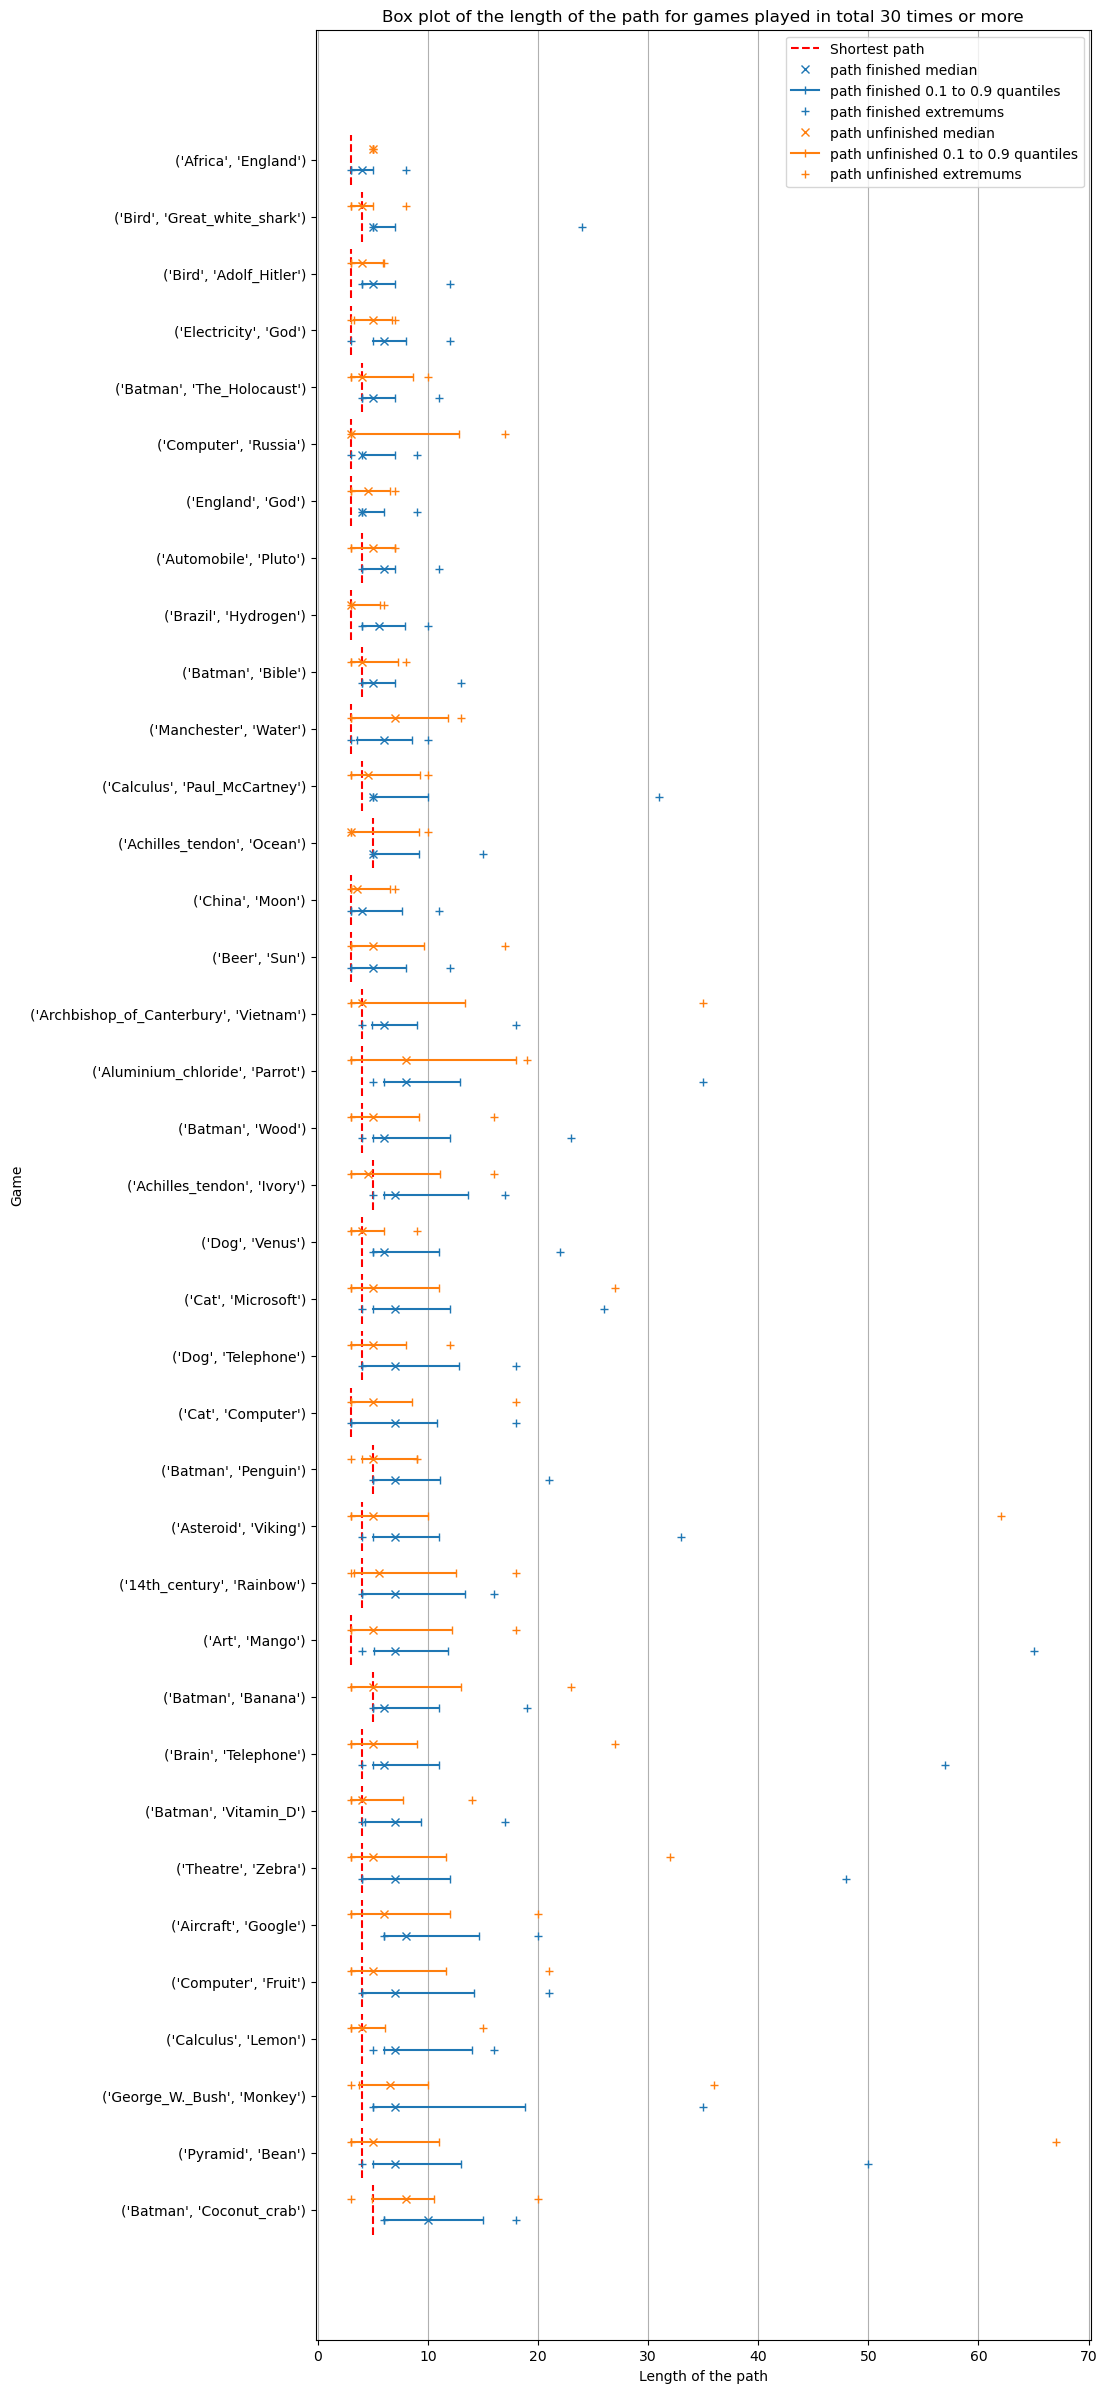

In [28]:
# NEXTSTEP:: eventually create function in plotting.py for better encapsulation, make it pretty
# NEXTSTEP:: hypothesis testing to check if the length of the paths for a same game 
# depend if the path reach the target or not  

n = len(stats_big_games.index)
y = np.arange(int(n*4), step=4)
plt.figure(figsize=(10,30))
gap=1.5

for i in range(n):
    plt.plot([stats_big_games['shortest_path'][i], stats_big_games['shortest_path'][i]], [y[i]-1, y[i]+gap+1], 'r--', label='Shortest path' if i==1 else '')

# plt.errorbar(stats_big_games['avg_f_path'], y, xerr=stats_big_games['sem_f_path']*1.96/2,
#              linestyle='', marker='+', capsize=4, label='Finished', color='tab:blue')
plt.plot(stats_big_games['med_f_path'], y, 'x', color='tab:blue', label='path finished median')
plt.plot([stats_big_games['q10_f_path'], stats_big_games['q90_f_path']], [y, y], '-|', color='tab:blue', label='path finished 0.1 to 0.9 quantiles')
plt.plot(stats_big_games['min_f_path'], y, '+', color='tab:blue', label='path finished extremums')
plt.plot(stats_big_games['max_f_path'], y, '+', color='tab:blue')

plt.plot(stats_big_games['med_unf_path'], y+gap, 'x', color='tab:orange', label='path unfinished median')
plt.plot([stats_big_games['q10_unf_path'], stats_big_games['q90_unf_path']], [y+gap, y+gap], '-|', color='tab:orange', label='path unfinished 0.1 to 0.9 quantiles')
plt.plot(stats_big_games['min_unf_path'], y+gap, '+', color='tab:orange', label='path unfinished extremums')
plt.plot(stats_big_games['max_unf_path'], y+gap, '+', color='tab:orange')
# plt.errorbar(stats_big_games['avg_unf_path'], y+1.5, xerr=stats_big_games['sem_unf_path']*1.96/2,
#              linestyle='', marker='+', capsize=4, label='Unfinished', color='tab:orange')

plt.title(f'Box plot of the length of the path for games played in total {num_games} times or more')
plt.yticks(y+0.75, stats_big_games.index)
plt.grid(axis='x')
plt.xlabel('Length of the path')
plt.ylabel('Game')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());

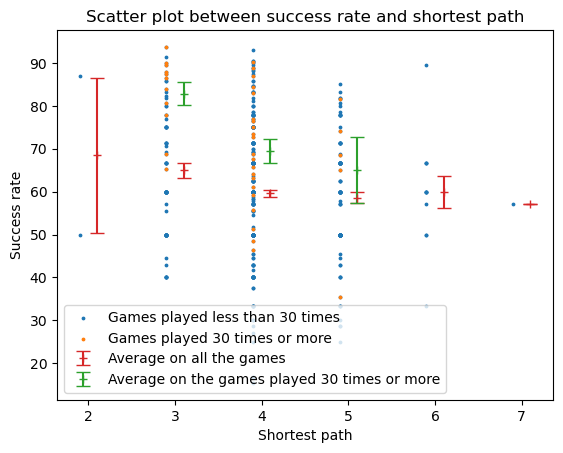

In [29]:
# NEXTSTEP:: eventually create function in plotting.py for better encapsulation

ms=3; cp=5; gap=0.1
plt.scatter(stats_games['shortest_path']-gap, stats_games['percentage_success'], s=ms, label=f'Games played less than {num_games} times')
plt.scatter(stats_big_games['shortest_path']-gap, stats_big_games['percentage_success'], s=ms, label=f'Games played {num_games} times or more')

plt.errorbar(np.arange(stats_games['shortest_path'].min(), stats_games['shortest_path'].max()+1)+gap, 
             stats_games[['percentage_success', 'shortest_path']].groupby('shortest_path').mean().values.flatten(), 
             yerr=stats_games[['percentage_success', 'shortest_path']].groupby('shortest_path').sem().fillna(0).values.flatten()*1.96/2, 
             linestyle='', marker='+', markersize=ms*2, capsize=cp, color='tab:red', label='Average on all the games')

plt.errorbar(np.arange(stats_big_games['shortest_path'].min(), stats_big_games['shortest_path'].max()+1)+gap,
             stats_big_games[['percentage_success', 'shortest_path']].groupby('shortest_path').mean().values.flatten(),
             yerr=stats_big_games[['percentage_success', 'shortest_path']].groupby('shortest_path').sem().fillna(0).values.flatten()*1.96/2,
             linestyle='', marker='+', markersize=ms*2, capsize=cp, color='tab:green', label=f'Average on the games played {num_games} times or more')

plt.xlabel('Shortest path')
plt.ylabel('Success rate')
plt.title('Scatter plot between success rate and shortest path')
plt.legend();

In the following, some linear regression have been done but further data analysis must be conducted (hypothesis testing + regression).

In [30]:
from sklearn.linear_model import LinearRegression

linReg = LinearRegression()
linReg.fit(np.arange(stats_games['shortest_path'].min(), stats_games['shortest_path'].max()+1).reshape(-1, 1), stats_games[['percentage_success', 'shortest_path']].groupby('shortest_path').mean().values.flatten())
linReg.coef_, linReg.intercept_

(array([-2.07176277]), 70.78647161959394)

In [31]:
linReg = LinearRegression()
linReg.fit(np.arange(stats_big_games['shortest_path'].min(), stats_big_games['shortest_path'].max()+1).reshape(-1, 1), stats_big_games[['percentage_success', 'shortest_path']].groupby('shortest_path').mean().values.flatten())
linReg.coef_, linReg.intercept_

(array([-8.9321719]), 108.18415245279795)

In [32]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

mod_all = smf.ols(formula='percentage_success ~ shortest_path', data=stats_games)
mod_all.fit().summary()

mod_mean = smf.ols(formula='percentage_success ~ shortest_path', data=stats_games[['percentage_success', 'shortest_path']].groupby('shortest_path').mean().reset_index())
mod_mean.fit().summary()

mod_big_mean = smf.ols(formula='percentage_success ~ shortest_path', data=stats_big_games[['percentage_success', 'shortest_path']].groupby('shortest_path').mean().reset_index())
mod_big_mean.fit().summary()


/bin/anaconda3/envs/ada/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 6 samples were given.

/bin/anaconda3/envs/ada/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 3 samples were given.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     percentage_success   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     12.28
Date:                Sat, 14 Dec 2024   Prob (F-statistic):              0.177
Time:                        16:59:10   Log-Likelihood:                -6.4561
No. Observations:                   3   AIC:                             16.91
Df Residuals:                       1   BIC:                             15.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       108.1842     10.408     10.395      0.061     -24.059     240.427
shortest_path    -8.9322      2.549     -3.504      0.177     -41.325      23.461
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.000
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.531
Skew:                          -0.707   Prob(JB):                        0.767
Kurtosis:                       1.500   Cond. No.                         21.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 1.2.2) Success rate and number of links to the target article
It seems natural that the more links lead to the target article, the easier is the game. Let's check this hypothesis.

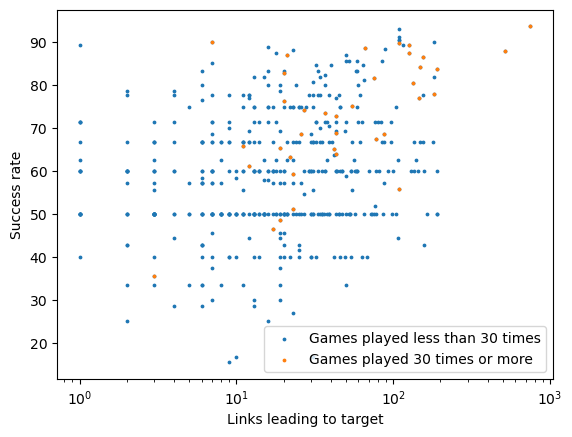

In [33]:

ms=3; cp=5; gap=0.1
plt.scatter(stats_games['links_to_target'], stats_games['percentage_success'], s=ms, label=f'Games played less than {num_games} times')
plt.scatter(stats_big_games['links_to_target'], stats_big_games['percentage_success'], s=ms, label=f'Games played {num_games} times or more')

plt.xlabel('Links leading to target')
plt.ylabel('Success rate')
plt.xscale('log')
plt.legend()

In the following, we explore the link between shortest path and success rate. A few linear regression have been done so far but further data analysis must be conduct.

In [34]:
mod_big = smf.ols(formula='percentage_success ~ log_links_to_target', data=stats_big_games)
mod_big.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     percentage_success   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     20.45
Date:                Sat, 14 Dec 2024   Prob (F-statistic):           6.73e-05
Time:                        16:59:11   Log-Likelihood:                -141.30
No. Observations:                  37   AIC:                             286.6
Df Residuals:                      35   BIC:                             289.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              44.3932      6.567      6.760      0.000      31.062      57.725
log_links_to_target     7.3221      1.619      4.522      0.000       4.035      10.609
==============================================================================
Omnibus:                        2.305   Durbin-Watson:                   0.805
Prob(Omnibus):                  0.316   Jarque-Bera (JB):                1.213
Skew:                           0.315   Prob(JB):                        0.545
Kurtosis:                       3.625   Cond. No.                         15.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 1.2.3) Combining the predictors
In this section we plan to find a model that combine the number of links to target and the shortest path. We might add other predictors not studied yet.